# Three-body problem animation

This is example of an animation of the 3-body problem. The notebook follows the presentation in 

https://github.com/tom26/JuliaFun/blob/master/2D%203-Body%20Problem.ipynb


We start by loading the relevant packages:

In [1]:
using Base64
using PyPlot
using OrdinaryDiffEq
using LinearAlgebra

In [2]:
using PyCall
@pyimport matplotlib.animation as animation

The system of ODEs we are gong to solve is as follows:

$$\frac{d^2\mathbf{r}_i}{dt^2} = \sum_j G\frac{m_j}{||\mathbf{r}_i-\mathbf{r}_j||^3}(\mathbf{r}_j-\mathbf{r}_i) ,$$

where $\mathbf{r}_i$ are position vectors for each mass.

We convert this into the following system of first order ODEs:

$$\begin{eqnarray}
\frac{d\mathbf{r}_i}{dt} & = & \mathbf{v}_i , \\
\frac{d\mathbf{v}_i}{dt} & = & \sum_j G\frac{m_j}{||\mathbf{r}_i-\mathbf{r}_j||^3}(\mathbf{r}_j-\mathbf{r}_i) .
\end{eqnarray}$$

Next, we introduce dimensionless units, measuring masses in units of $M_0$, distances in units of $R_0$, and time in units of $T_0$. The choice of $M_0$, $R_0$, and $T_0$ is at this stage arbitrary, except the parameters must satisfy the relation $$G \frac{T_0^2 \, M_0}{R_0^3} = 1 .$$ We measure velocities in units of $R_0/T_0$ and accelerations in the units of $R_0/T_0^2$.

The equations of motion are as follws,
$$\begin{eqnarray}
\frac{d\mathbf{r}_i}{dt} & = & \mathbf{v}_i , \\
\frac{d\mathbf{v}_i}{dt} & = & \sum_j \frac{m_j}{||\mathbf{r}_i-\mathbf{r}_j||^3}(\mathbf{r}_j-\mathbf{r}_i) .
\end{eqnarray}$$, where we keep the notations $\mathbf{r}_j$, $\mathbf{v}_j$, $m_j$, and $t$ but those variables are now dimensionless. 

We encode all of the position and velocity vectors in one vector $y$, in the format:

$$y = [\text{First Planet's Position}, \text{First Planet's Velocity}, \text{Second Planet's Position}, \text{Second Planet's Velocity},\ldots]$$

To start, we must define the right hand side of the sytem above, as this is what the ODE solver requires.

In [3]:
"""
    forcef(a1, a2)

Gravitational (attraction) force acting on a mass in 'a2' from a mass in 'a1'
(sans scalar mass and G factors).
"""
@inline function forcef(a1, a2)
    d = a1 - a2
    return d / norm(d)^3
end

forcef

In [4]:
"""
    totalenergy(u, p)

Total energy of a three-body system
"""
@views function totalenergy(u, p)
    # unpack variables and parameters
    r1, r2, r3 = u[1:2], u[5:6], u[9:10]     # position vectors
    v1, v2, v3 = u[3:4], u[7:8], u[11:12]    # velocity vectors
    m1, m2, m3 = p[1], p[2], p[3]            # masses

    T = (m1 * norm(v1)^2 + m2 * norm(v2)^2 + m3 * norm(v3)^2) / 2
    V = -(m1 * m2 / norm(r1 - r2) + m1 * m3 / norm(r1 - r3) + m2 * m3 / norm(r2 - r3))

    return T + V
end

totalenergy

Let's define the right hand side of the sytem above.

In [5]:
@views function threebody!(dudt, u, p, t)
    # unpack variables and parameters
    r1, r2, r3 = u[1:2], u[5:6], u[9:10]     # position vectors
    v1, v2, v3 = u[3:4], u[7:8], u[11:12]    # velocity vectors
    m1, m2, m3 = p[1], p[2], p[3]            # masses

    # The derivatives of the position are the velocities
    dr1dt = v1
    dr2dt = v2
    dr3dt = v3

    # Calculate the force factors between the bodies
    d1 = forcef(r3, r2)
    d2 = forcef(r1, r3)
    d3 = forcef(r2, r1)

    # Calculate the accelerations

    # Expressions for dv1dt, dv2dt, and dv3dt that reuse d1, d2, and d3
    dv1dt = m2 * d3 - m3 * d2
    dv2dt = m3 * d1 - m1 * d3
    dv3dt = m1 * d2 - m2 * d1

    # Assemble the derivative vector
    dudt .= [dr1dt; dv1dt; dr2dt; dv2dt; dr3dt; dv3dt]

    return nothing
end


threebody! (generic function with 1 method)

We can now set the parameters and integrate the equations of motion.

In [6]:
# Planetary masses
m1 = 5.0
m2 = 4.0
m3 = 3.0

m = [m1, m2, m3];

In [7]:
# Initial positions and velocities 
r10 = [ 1.01, -1.0]    
v10 = [ 0.0,   0.0]
r20 = [ 1.0,   3.0]    
v20 = [ 0.0,   0.0]
r30 = [-2.0,  -1.0]  
v30 = [ 0.0,   0.0]
pos0 = vcat(r10, v10, r20, v20, r30, v30);

In [8]:
E0 = totalenergy(pos0, m)

-12.38337307939218

In [9]:
# Simulation time
tf = 50.0
tspan = (0.0, tf)

# Solve the system
prob = ODEProblem(threebody!, pos0, tspan, m)
sol = solve(prob, Tsit5(), abstol=1e-10, reltol=1e-10);

In [11]:
stepsPerUnitTime = 330
np = Int(round(tf)) * stepsPerUnitTime;

In [12]:
t = range(tspan[1], tspan[2], np)
s = sol(t);

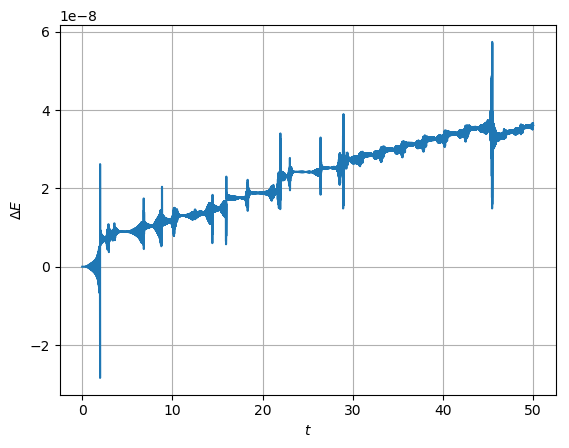

In [13]:
# Energy change
energy = zeros(np);
for i = 1:np
    energy[i] = totalenergy(s[i], m) - E0
end

figure(1)
plot(t, energy)
grid(true)
xlabel(L"t")
ylabel(L"\Delta E");

## Trajectory

In [14]:
# Extract coordinates
x1 = s[1, :];
y1 = s[2, :];

x2 = s[5, :];
y2 = s[6, :];

x3 = s[9, :];
y3 = s[10, :];

traj = (x1, x2, x3, y1, y2, y3);

In [15]:
# Find axis limits
rxs = vcat(x1, x2, x3)
xmin = minimum(rxs)
xmax = maximum(rxs)
xmin = xmin - 0.1*(xmax - xmin) 
xmax = xmax + 0.1*(xmax - xmin)

rys = vcat(y1, y2, y3)
ymin = minimum(rys)
ymax = maximum(rys)
ymin = ymin - 0.1*(ymax-ymin) 
ymax = ymax + 0.1*(ymax-ymin);

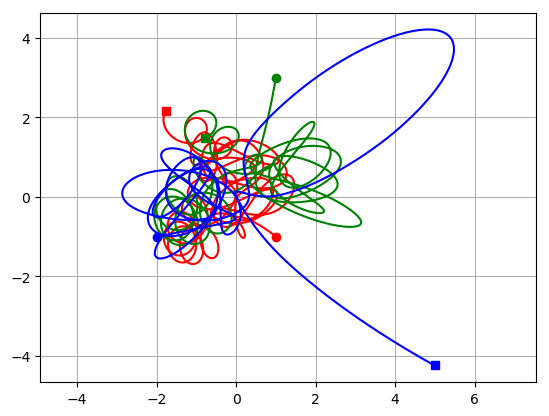

In [16]:
figure(2)
xlim(xmin, xmax)
ylim(ymin, ymax)
grid(true)
axis("equal")
plot(x1, y1, "r-")
plot(x2, y2, "g-")
plot(x3, y3, "b-")
    
# Plot the start and end points\n",
    
plot(x1[1], y1[1], "ro")
plot(x1[end], y1[end], "rs")
plot(x2[1], y2[1], "go")
plot(x2[end], y2[end], "gs")
plot(x3[1], y3[1], "bo")
plot(x3[end], y3[end], "bs");

## Animation

A tutorial on making animations with Matplotlib:

https://medium.com/@qiaofengmarco/animate-your-data-visualization-with-matplotlib-animation-3e3c69679c90

In [17]:
# Turn interactive plotting off to avoid plotting of an empty figure
# pygui(true)
ioff();

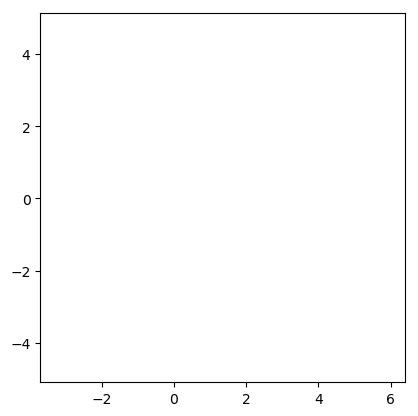

In [18]:
# Initiate the figure and the artists
fig = figure()

xlim(xmin, xmax)
ylim(ymin, ymax)

ax = gca()

ax.set_aspect(1);

line1 = ax.plot([], [], "r-")[1]
line2 = ax.plot([], [], "g-")[1]
line3 = ax.plot([], [], "b-")[1]

p1 = ax.plot([], [], "or")[1]
p2 = ax.plot([], [], "og")[1]
p3 = ax.plot([], [], "ob")[1];

In [19]:
step = 10 # plot every step's datapoint
taillen = 50

@views function animate!(i, step, taillen, traj, line1, line2, line3, p1, p2, p3)
    k = i + 1
    m = max(1, step*(k-taillen))
    n = step*k
    
    x1, x2, x3, y1, y2, y3 = traj
    
    line1.set_data(x1[m:n], y1[m:n])
    line2.set_data(x2[m:n], y2[m:n])
    line3.set_data(x3[m:n], y3[m:n])
    
    p1.set_data([x1[n]], y1[n])
    p2.set_data([x2[n]], y2[n])
    p3.set_data([x3[n]], y3[n])
    
    # return (line1, line2, line3, nothing) # if blit=false
    return (line1, line2, line3) # if blit=true
end

animate! (generic function with 1 method)

In [20]:
# Call the animator:
#   the 'frames' parameter determines the length of the animation
#   the 'interval' parameter determines time in milliseconds between drawing of two frames
anim = animation.FuncAnimation(fig, animate!,
                               frames=Int(floor(np/step)), interval=20,
                               fargs=[step, taillen, traj, line1, line2, line3, p1, p2, p3], blit=true);

In [21]:
filename = "three-body-2d.mp4"
# This requires ffmpeg to be installed
anim.save(filename, bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])

## Embedded animation

In [22]:
# Function for creating an embedded video given a filename
function html_video(filename)
    open(filename) do f
        base64_video = base64encode(f)
        """<video controls src="data:video/x-m4v;base64,$base64_video">"""
    end
end

display("text/html", html_video(filename))

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQADThxtZGF0AAACrgYF//+q3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyByMjk4MCAzNGMwNmQxIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxOSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTYgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAGSWWIhAAz//727L4FNf2f0JcRLMXaSnA+KqSAgHc0wAAAAwAAAwAABIRT+ionVsXUeAAAAwJaAJHE/9hotf+AAyw7rZPsOrv5bFjBpHzgEaFQ4T7atPUxveCha4BBjfnJMAiS9vUS3GKFDEWxJHQr3JCxcZ3jYX5qGr1uWYDoflyYl+i8yG7fZBtrhKxyAARrkbb5KLUy+wWMJrRNGj6LIR9YVJd/h8kQifssjaRi0vagBGner6+G/pavEoh1mK8sR/2gZBc+OtRKo+/3y7L/chYXG/PvMxZAnnNe5JY1hh0wLApzvDY5O5dD1Irmehd0ktO4d4f6qsbP/179aBKdS5kYBjs/jtN4FS1EdZhaQ1e8s2lnmO9IQZGr0KAHSZDCzBcIV6UZbtjnjCKLqxMpRBhJB2L2+ldolL3DTERkmGavOYhrBHwN9fq7cFATL8asLQT8upM4dYYdZsorSNVqUHEaGuc+ZreX0ua8q7Zwk6zm0qonFL5/z51/eubWHWRUelReZdJgPecvZP0JDcBru2BjV3JKBGXKAJBEtwFkS1H1DrgHl8wDsWLSdZKf6C0n7j/B61r2UOy9T2VbXylG8xCtFKAAAAMALybu3XqdPMnsdr5oyeW/9BnCMojbsDrKQBLoQldfV2gP7nw7eCEC4BEFIx/RpY5uSj3SgGy2C26wjWyNMUwghg6mNFbkBNo3kkvB7rmDU83pEaGu8ZeSMI+TE+u8CvaX0nnEV/2CeG7MX/gVBBgS60zNXK2gAbcAYgwzURJlzN+UNmDjwbGqAALRzVsGHrOE2NrESUT4VSabqpW5REewCJH3eWpUC+AaktoZHUWzERWhjNumPkP18PKlzrzyhR0w1VvRdUOiuTxzByZlX/uqLpr1CetMDC0APSg8qt6B+DAi7Vx3MskmxTsxKPglBs4KX5pYu5KfHUDMo0zt2IKR9Ezip4BreBzZVbAb992Wb3HiGyteV1t+zg31H/t7NVvKgr3uGEWG7X+i00WJk9OBP30oWWfXev1+aMfjcp2p/4mOi050VHpK84xTkLD6oepE2ECGJsxwGNnVSEccocDiwABJ/+ZXuV0fg9ZyOCC6pg8916DUpWD7du52ppZWDlwweZJSVhbf7eAovPuAKMeUVP+C0ycV4FP/VRoWNajjNYuXe0G+zCk5Acp/TxUAd5AENlDwVoQRQYTNbvN/K3xsIEi61+2nY4QAGsCKQw53D+f2KrfWigQABPpY7SLRyxWfgVsKJK9S0g0d3uYiDZd999pHOUrr7P8IelVRJs58IjxgAAIMO00yoAAAMJYReYqSPL6ttPKXa5yA2BckSiXCZ6oopnAapbUBpwThVKyuHwXlWTRpCaCkASVH9KGo0sQCuBE6N0xVIyqXjJZapwiskqUjLzaO5fiMSLb2eszlXPdI+ZMMSyGmSbRQjmRm41nxvRDU8kBgJukmGIDRWdhYU65I1YA4KSRXAACODgn+WXtx+BshIpvdZ0TiX+D8QT0KzZOt6vmbUKqeQK4nZYoSiOSQc6GT74p/HjnulwilCbwdn/5zLdAwQftA0RqiaH8R/z8QTfDZbRjj64RQv5cNPqaeckNvojL8Etot9g+a7Ht07DCxyhKVwAS3Ip0RvVARZTaXwYpWlq5FUhlZQwVxKqFKW6bH4KFe+86nzg2XPcWqTwBa68IAi0AqSSwiCBBDq/ZA6XqOPSkp+myQGo0UyQVemr3l1xJyBVFPg8UFyFafREuUe/4tA8PuywAMfWq0y6uSk1ztwR2ITTAPoqwkC5Y5IVjJJbWrMO64fUUk3vLfwIJ2JLC7RrwKSqQK2qUuofWu7otV9gvemd6mvkX/7C979/c/1xkCma18K/Ne6TlskkYVnR5go0F/xbBsvGRdIvR3OOVFVX72ixnADya+J0RY0CIFBPcHJJJ8hTG2GtUfQu/vxq2t2pFSK32zSzTj4NDYMwY78t4PJh/y4X0/UIchDzi8ttmwWiQhPcCbYjA6Z+FZO2bYDRhSO8t+vFOI06ywMc7++9ZZWPYtgjnEghG0Hks4KhQEmNt4aC0UHzfVxBluOz4iBb9EFHPFy52x5voTu0sTB/9ObVXRED4V+nkqaVrB2/53mN4d1j76HXGFm8zslQhMnQAAVvMSLsoABSUAAAA0QZokbEM//p4QAAADAAlrtaIlXFjoycETpkgBA1gvdm26kyyLK4+ZnPI1d3YqpWWDE9CYkAAAABlBnkJ4hH8AAAMAAxFxcJlxwGYcCjz4bZ/NAAAAEQGeYXRH/wAAAwAElYdqAEvAAAAAFQGeY2pH/wAAAwAE1+CJqMkL9ADZgQAAAGNBmmhJqEFomUwIZ//+nhAAAT3iA6aLOaBQptk0NVxfgYNvXn5or6aCQiFCVjLyVD+zqmfP5H2UVEKf9W0017uQca1Jd4bG/1ftn6zaDxiH4yE2aRBxuH5ij9m/kqaz+WSzhhEAAAAfQZ6GRREsI/8AAGcmBWmjQipGIKXcjI191oEA5yZBHwAAABEBnqV0R/8AAAMADS4TpABAwQAAABcBnqdqR/8AAKPmEuYiG6fxwR/I6fACFgAAACNBmqxJqEFsmUwIZ//+nhAAAAMACWohx8M8s9jtG4vWvqALuAAAABpBnspFFSwj/wAAAwAIMVAY3p5mwKxaq9JB4QAAABEBnul0R/8AAAMADS4TpABAwAAAABQBnutqR/8AAAMADTSfV8cGcgCZgAAAAFtBmvBJqEFsmUwIZ//+nhAAAT3iBBdNtgpr/gbjoU84Uzumog33MGs81YhHvKYEkUSoKKr9dOwNZrklLd/dmNX36ShhEHMDX43zDVoMjHaJcUd/MVixkDU83tZhAAAAKkGfDkUVLCP/AABnJg880IyZ5rDL+p5s1K9RIvMAzB3Ko/dFcAZQHtPKSQAAABcBny10R/8AAAMADS4h47EIB0B/5/RogQAAABoBny9qR/8AAKOmAmI